In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import os

In [2]:
# change height

def img_graph(input_data, height = 64):
    
    data = input_data.copy()
    
    lenght = 3 * len(data)
    
    im = Image.new(mode = '1', size = (lenght, height))
    
    volume_height = round(height * 0.2)
    volume_max = data['VOL'].max()
    vol = round((data['VOL'] / volume_max) * volume_height - volume_height * 0.05)
    
    vol[vol == 0] = 1
    
    vol[vol == vol.max()] = vol.max() - 1
    data.loc[:, 'VOL'] = vol
    
    maximum = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'MA']].max().max()
    minimum = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'MA']].min().min()
    
    price_height = height - volume_height
    data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'MA']] = round(((data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'MA']] - minimum)/(maximum - minimum)) * price_height)
    
    matrix = pd.DataFrame(np.array(im))

    for i,j in zip(range(1, lenght - 1, 3), data.index):
        
        o = price_height - int(data.loc[j,'OPENPRC'])
        h = price_height - int(data.loc[j,'ASKHI'])
        l = price_height - int(data.loc[j,'BIDLO'])
        c = price_height - int(data.loc[j,'PRC'])
        ma = price_height - int(data.loc[j, 'MA'])
        v = -int(data.loc[j, 'VOL'])
        if o < 0 or h < 0 or l < 0 or c < 0:            
            matrix.iloc[v:, int(i)] = True
        else:
            matrix.iloc[int(o),int(i) - 1] = True
            matrix.iloc[int(h):int(l) + 1, int(i)] = True
            matrix.iloc[int(c), int(i) + 1] = True
            matrix.iloc[int(ma), int(i) - 1 : int(i) + 1] = True
            matrix.iloc[v:, int(i)] = True

            

# #             matrix.iloc[int(h):int(l) + 1, int(i)] = True
# #             matrix.iloc[int(c), int(i) + 1] = True
# #             matrix.iloc[v:, int(i)] = True
# #         elif h < 0 or l < 0:
# #             matrix.iloc[int(o),int(i) - 1] = True
# #             matrix.iloc[int(c), int(i) + 1] = True
# #             matrix.iloc[v:, int(i)] = True
# #         elif c < 0:
# #             matrix.iloc[int(o),int(i) - 1] = True
# #             matrix.iloc[int(h):int(l) + 1, int(i)] = True
# #             matrix.iloc[v:, int(i)] = True
#         else:
#         matrix.iloc[int(o),int(i) - 1] = True
#         matrix.iloc[int(h):int(l) + 1, int(i)] = True
#         matrix.iloc[int(c), int(i) + 1] = True
#         matrix.iloc[v:, int(i)] = True

    graph = Image.fromarray(np.array(matrix))
#     graph.show()
    return(graph)

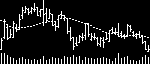

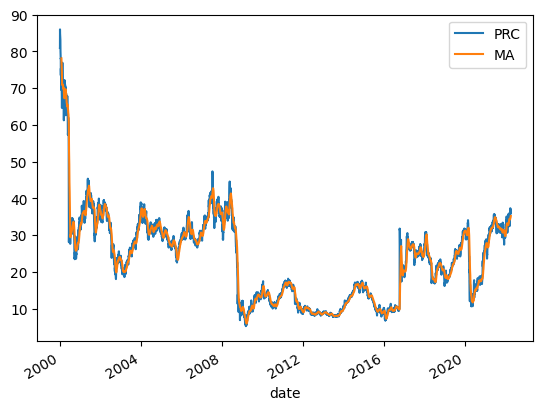

In [15]:
# PRC -- CLOSE
# BIDLO -- LOW
# ASKHI -- HIGH
# OPENPRC -- OPEN
# BID -- CLOSE BID
# ASK -- CLOSE ASK
# VOL -- VOLUME
# RET -- RETURN

data.head()
data_step1 = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'VOL']]
data_step1['MA'] = data_step1['PRC'].rolling(20).mean()
data_step1[['PRC', 'MA']].plot()

img_graph(data_step1.iloc[50:100, :])

In [8]:
data = pd.read_csv('Data/AA.csv', index_col = 1, parse_dates = ['date'])

In [9]:
data_step1 = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'VOL']]
data_step1['PRC'] = abs(data_step1['PRC'])

In [10]:
# define parameters m and n
# m lenght of observation picture
# n lenght of prediction picture

m = 20
n = 5

lookback = data_step1.iloc[1:21, :]
lookback_class = data_step1.iloc[21:26, :]
ret = lookback_class.iloc[-1, -2] - lookback_class.iloc[0, 0]

# buy signal -- 1
# sell signal -- 0

if ret > 0:
    signal = 1
else:
    signal = 0
    
lookback_class.head()

,OPENPRC,ASKHI,BIDLO,PRC,VOL
date,,,,,
2000-02-02,71.6875,75.5625,71.5625,74.5625,2792500.0
2000-02-03,74.5625,74.5625,71.3750,72.2500,1442500.0
2000-02-04,72.5000,72.5000,69.7500,70.5000,1474699.0
2000-02-07,70.8125,70.8125,68.1250,68.1250,2473500.0
2000-02-08,69.0000,69.0625,65.8750,65.9375,3408099.0


In [3]:
def dataset_creation(big_data, observation_period, test_period, subset, a_count = 0, b_count = 0, c_count = 0):
    
#     big_data: stock price data given from excel
#     observation_period: picture timeframe in days
#     test_period: performance period for labeling
#     subset: whether data is for training or testing ["Train", "Test"]
    
    l = len(big_data)
    iterations = round(l/(observation_period + test_period)) - 1
    
#     labels = pd.DataFrame(index = range(iterations), columns = ['Label'])

    pic_path = f"Dataset/Pics_{observation_period}_{test_period}/{subset}/class_a"
    
    if os.path.isdir(pic_path) == True:
        pass
    else:
        os.makedirs(pic_path)

    pic_path1 = f"Dataset/Pics_{observation_period}_{test_period}/{subset}/class_b"
    
    if os.path.isdir(pic_path1) == True:
        pass
    else:
        os.makedirs(pic_path1)
        
#     pic_path2 = f"Dataset/Pics_{observation_period}_{test_period}/{subset}/class_c"
    
#     if os.path.isdir(pic_path2) == True:
#         pass
#     else:
#         os.makedirs(pic_path2)

    for i in range(iterations):
        
        signal = None
        ret = None
        
        lookback = big_data.iloc[i * observation_period : (i + 1) * observation_period, :]
        lookback_class = big_data.iloc[(i + 1) * observation_period : (i + 1) * observation_period + test_period]

#         print(lookback)
#         print(lookback_class)
        try:
            ret = (int(lookback_class.iloc[-1, -3]) - int(lookback_class.iloc[0, 0]))#/int(lookback_class.iloc[0, 0])
        except:
            ret = (int(lookback_class.iloc[-1, :-3].mean()) - int(lookback_class.iloc[0, :-2].mean()))#/int(lookback_class.iloc[0, :-2].mean())

        # buy signal -- 1
        # sell signal -- 0

        if ret > 0: #0.005:
            signal = 1
#         elif ret < -0.005:
#             signal = -1
        else:
            signal = 0
            
        graph = img_graph(lookback)
        
        if signal == 1:
            graph.save(f"Dataset/Pics_{observation_period}_{test_period}/{subset}/class_a/a_image_{a_count}.jpeg")
            a_count += 1
#         elif signal == -1:
#             graph.save(f"Dataset/Pics_{observation_period}_{test_period}/{subset}/class_b/b_image_{b_count}.jpeg")
#             b_count += 1
        elif signal == 0:
            graph.save(f"Dataset/Pics_{observation_period}_{test_period}/{subset}/class_b/b_image_{b_count}.jpeg")
            b_count += 1
        else:
            print('You have an error')
    
#     label_path = f"Dataset/{ticker}/Labels"
    
#     if os.path.isdir(label_path) == True:
#         pass
#     else:
#         os.makedirs(label_path)
        
#     labels.to_csv(f"Dataset/{ticker}/Labels/Labels_{observation_period}_{test_period}.csv")
    return(a_count, b_count)
    
# dataset_creation(data.iloc[:100], 20, 5, 'AA')

In [16]:
directory = r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\Data"

tickers = ["AAPL", 'MSFT']

subset = 'Val'

a = 0
b = 0
c = 0
# for root, dirs, files in os.walk(directory):
#     for file in files:
#         if file.endswith('.csv'):
#             sample = pd.read_csv(os.path.join(root, file), index_col = 1, parse_dates = ['date'])
#             # filtered by daily volume: 250000+
#             if (np.array(sample['VOL']) > 250000).all() == True: # and (np.array(sample['OPENPRC']) != 'nan').all():
#                 symb = file[:-4]
#                 tickers.append(symb)
#             else: pass
for tick in tickers:
    data = pd.read_csv(f'{subset}_Data/{tick}.csv', index_col = 0, parse_dates = ['date'])
    data_step1 = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'VOL']]
    data_step1['MA'] = data_step1['PRC'].rolling(20).mean()
    data_step1 = data_step1.iloc[21:, :]
    #     data_step1['PRC'] = abs(data_step1['PRC'])
    data_step1.fillna(0, inplace = True)
    a, b = dataset_creation(data_step1, 20, 5, subset, a, b, c)            

In [4]:
a = 0
b = 0
c = 0
# subset = ['Train', 'Test', 'Val']
subset = 'Train'
directory = r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\{}_Data".format(subset)

tickers = []

for root, dirs, files in os.walk(directory):
    for file in files:
        sample = pd.read_csv(os.path.join(root, file), index_col = 1, parse_dates = ['date'])
        # filtered by daily volume: 250000+
        if (np.array(sample['VOL']) > 250000).all() == True: # and (np.array(sample['OPENPRC']) != 'nan').all():
            symb = file[:-4]
            tickers.append(symb)
        else: pass

for tick in tickers:
    try:
        data = pd.read_csv(f'{subset}_Data/{tick}.csv', index_col = 0, parse_dates = ['date'])
        data_step1 = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'VOL']]
        data_step1['MA'] = data_step1['PRC'].rolling(20).mean()
        data_step1 = data_step1.iloc[21:, :]
        #     data_step1['PRC'] = abs(data_step1['PRC'])
        data_step1.fillna(0, inplace = True)
        a, b = dataset_creation(data_step1, 20, 5, subset, a, b, c)
    except:
        print(f'{tick}: Raise Error')

In [5]:
a = 0
b = 0
c = 0
# subset = ['Train', 'Test', 'Val']
subset = 'Test'
directory = r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\{}_Data".format(subset)

tickers = []

for root, dirs, files in os.walk(directory):
    for file in files:
        sample = pd.read_csv(os.path.join(root, file), index_col = 1, parse_dates = ['date'])
        # filtered by daily volume: 250000+
        if (np.array(sample['VOL']) > 250000).all() == True: # and (np.array(sample['OPENPRC']) != 'nan').all():
            symb = file[:-4]
            tickers.append(symb)
        else: pass

for tick in tickers:
    try:
        data = pd.read_csv(f'{subset}_Data/{tick}.csv', index_col = 0, parse_dates = ['date'])
        data_step1 = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'VOL']]
        data_step1['MA'] = data_step1['PRC'].rolling(20).mean()
        data_step1 = data_step1.iloc[21:, :]
        #     data_step1['PRC'] = abs(data_step1['PRC'])
        data_step1.fillna(0, inplace = True)
        a, b = dataset_creation(data_step1, 20, 5, subset, a, b, c)
    except:
        print(f'{tick}: Raise Error')

In [6]:
a = 0
b = 0
c = 0
# subset = ['Train', 'Test', 'Val']
subset = 'Val'
directory = r"C:\Users\hayk.darbinyan\codes\my_Venvs\_venv-310-jupyter\Thesis\{}_Data".format(subset)

tickers = []

for root, dirs, files in os.walk(directory):
    for file in files:
        sample = pd.read_csv(os.path.join(root, file), index_col = 1, parse_dates = ['date'])
        # filtered by daily volume: 250000+
        if (np.array(sample['VOL']) > 250000).all() == True: # and (np.array(sample['OPENPRC']) != 'nan').all():
            symb = file[:-4]
            tickers.append(symb)
        else: pass

for tick in tickers:
    try:
        data = pd.read_csv(f'{subset}_Data/{tick}.csv', index_col = 0, parse_dates = ['date'])
        data_step1 = data.loc[:, ['OPENPRC', 'ASKHI', 'BIDLO', 'PRC', 'VOL']]
        data_step1['MA'] = data_step1['PRC'].rolling(20).mean()
        data_steo1 = data_step1.iloc[21:, :]
        #     data_step1['PRC'] = abs(data_step1['PRC'])
        data_step1.fillna(0, inplace = True)
        a, b = dataset_creation(data_step1, 20, 5, subset, a, b, c)
    except:
        print(f'{tick}: Raise Error')